# Yelp Regression Model

#### CSC 180

#### Chandu Kathi, ID - 220 276 356
#### Priyatham Dasigandla, ID - 302 745 365
#### Wenshen Zhong, ID - 301 491 723

In [35]:
# Import Statements
%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure, show
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD


In [36]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Import Business and Review Data

In [37]:
# Convert Data from JSON to Pandas
reviews = pd.read_json('yelp_academic_dataset_review.json', lines=True, nrows=1000000)

business = pd.read_json('yelp_academic_dataset_business.json', lines=True, nrows=1000000)

# Rename to distinguish star ratings after join
reviews = reviews.rename(columns={'stars': 'review_rating'})
business = business.rename(columns={'stars': 'business_rating'})


# Data Preprocessing

In [38]:
# Add Location Column
business['location'] = business['city'] + ", " + business['state']

# Filter businesses out (review_count < 20 and null business_id & review_count)
business =  business[business.review_count > 20]

In [39]:
# Merge the business and reviews together 
all_reviews = pd.merge(reviews,business, on='business_id') 

# print(all_reviews.columns)
# all_reviews.head()
# all_reviews.head()

In [40]:
# Combine all the business's reviews into one text
business_reviews = all_reviews.groupby('business_id')['text'].sum()

# # Create a dataframe with the business and its all its cooresponding reviews
df_business_reviews = pd.DataFrame({
  'business_id' : business_reviews.index, 
  'all_reviews' : business_reviews.values,
})

df_business_reviews = pd.merge(df_business_reviews, business[['business_id', 'location', 'review_count', 'business_rating']], on='business_id')

In [41]:
# One hot encoding for location
df_encoded = pd.get_dummies(df_business_reviews['location'])
df_business_reviews = pd.concat([df_encoded, df_business_reviews], axis=1)

# Drop location column now that one)
df_business_reviews.drop(['location'], axis=1, inplace=True)


# Replace nulls with mean and normalize review count for the business
missing_median(df_business_reviews, 'review_count')
encode_numeric_zscore(df_business_reviews, 'review_count')

# df_business_reviews.head()

# TF-IDF Vectorizer

In [42]:
text = df_business_reviews['all_reviews']
# text.head()

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,min_df=1)
# Fit and transform the aggregated reviews into a TF-IDF matrix
tfidf_wm = vectorizer.fit_transform(text)

# Retrieve the feature names (i.e., the vocabulary)
tfidf_tokens = vectorizer.get_feature_names_out()

# Create a DataFrame from the TF-IDF matrix for easier viewing
df_tfidfvect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

In [43]:
df_tfidfvect.head()

,00,10,100,11,12,15,20,25,30,40,...,wow,write,wrong,year,years,yelp,yes,young,yum,yummy
0,0.016924,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.013035,0.0,...,0.000000,0.0,0.013172,0.013337,0.035272,0.014962,0.00000,0.000000,0.04136,0.0
1,0.000000,0.000000,0.000000,0.0,0.063727,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.046635,0.000000,0.00000,0.000000,0.00000,0.0
2,0.000000,0.002966,0.018577,0.0,0.004180,0.017596,0.023668,0.008851,0.010174,0.0,...,0.004299,0.0,0.013708,0.024289,0.076472,0.019463,0.00372,0.004425,0.00000,0.0
3,0.127470,0.000000,0.067228,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.062224,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.095760,0.000000,0.00000,0.000000,0.00000,0.0


# Train-Test Split

In [44]:
# Combine x and y into a single DataFrame
df_combined = pd.concat([df_tfidfvect, df_business_reviews['business_rating']], axis=1)

# Use the to_xy function to convert the DataFrame to x and y arrays
x, y = to_xy(df_combined, 'business_rating')

# Now split the transformed data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Check the shape of the resulting arrays
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9216, 1000) (9216,) (2304, 1000) (2304,)


# Yelp Models Testing

In [45]:
def model_tester(hidden_layers=[], activation_function='relu', optimizer='adam', batch_size=32, learning_rate=0.01, dropout_rate=0.0): 
  '''Uses the parameters to train a model and returns predictions and RMSE score'''

  # Initialize Optimizers
  adam = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
  sgd = optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)  

  # Create the model
  model = Sequential()

  for i in hidden_layers: 
    model.add(Dense(i, activation=activation_function))
    if dropout_rate > 0 and i % 2 == 1:
      model.add(Dropout(dropout_rate))

  model.add(Dense(1))

  # Choose the optimizer
  if optimizer == 'adam': 
    model.compile(loss='mean_squared_error', optimizer=adam)
  else: 
    model.compile(loss='mean_squared_error', optimizer=sgd)

  # Initialize ModelCheckpoint and EarlyStopping
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
  checkpointer = ModelCheckpoint(filepath="dnn/best_weights1.keras", verbose=0, save_best_only=True)

  # Fit the model to the train data
  model.fit(
    x_train,y_train, validation_data=(x_test,y_test), 
    batch_size=batch_size, callbacks=[monitor, checkpointer],
    verbose=2,epochs=100
  )

  model.load_weights('dnn/best_weights1.keras') # load weights from best model

  # Predict and measure RMSE
  pred = model.predict(x_test)
  score = np.sqrt(metrics.mean_squared_error(pred,y_test))

  return (score, pred)

#### All Model's and Paramenters

In [46]:
model_types = [
    # 3 Hidden Layers
    {'hidden_layers': [256, 128, 64], 'activation_function': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'sigmoid', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'sigmoid', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 

    # 4 Hidden Layers
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'sigmoid', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'sigmoid', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 

    # Variety of models with relu and sgd
    # 3 hidden layers
    {'hidden_layers': [512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 16},
    {'hidden_layers': [512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},

    # 4 hidden layers
    {'hidden_layers': [1024, 512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 16},
     {'hidden_layers': [1024, 512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 16},
    {'hidden_layers': [1024, 512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32},

    # Custom hidden layers
    {'hidden_layers': [160, 80, 40, 20, 10, 5], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.1, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},
    {'hidden_layers': [1024, 2048, 1024, 512, 1024, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},
    {'hidden_layers': [1024, 2048, 1024, 512, 1024, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.3, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 16},
    {'hidden_layers': [1024, 2048, 516, 256, 128, 2048, 128, 256, 512, 2048], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},
    {'hidden_layers': [1024, 2048, 516, 256, 128, 2048, 128, 256, 512, 2048], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.5, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 64},
    {'hidden_layers': [4096, 1024, 256, 128, 64, 32], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.4, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},
]

model_results = []

In [48]:
model_results = []

# Run all the different models specified above
for model in model_types:
    hidden_layer = model['hidden_layers']
    activation_function = model['activation_function']
    optimizer = model['optimizer']
    dropout_rate = model['dropout_rate']
    learning_rate = model['learning_rate']
    batch_size = model['batch_size']
    
    results = model_tester(
        hidden_layers=hidden_layer, 
        learning_rate=learning_rate, 
        optimizer=optimizer,
        activation_function=activation_function, 
        dropout_rate=dropout_rate, 
        batch_size=batch_size
    )

    model_results.append(results)

Epoch 1/100
288/288 - 4s - loss: 0.4281 - val_loss: 0.2263 - 4s/epoch - 15ms/step
Epoch 2/100
288/288 - 2s - loss: 0.1810 - val_loss: 0.1921 - 2s/epoch - 6ms/step
Epoch 3/100
288/288 - 2s - loss: 0.1569 - val_loss: 0.1864 - 2s/epoch - 6ms/step
Epoch 4/100
288/288 - 2s - loss: 0.1339 - val_loss: 0.1752 - 2s/epoch - 7ms/step
Epoch 5/100
288/288 - 1s - loss: 0.1184 - val_loss: 0.1727 - 1s/epoch - 5ms/step
Epoch 6/100
288/288 - 2s - loss: 0.1006 - val_loss: 0.2102 - 2s/epoch - 5ms/step
Epoch 7/100
288/288 - 1s - loss: 0.0848 - val_loss: 0.1648 - 1s/epoch - 5ms/step
Epoch 8/100
288/288 - 1s - loss: 0.0733 - val_loss: 0.1881 - 1s/epoch - 5ms/step
Epoch 9/100
288/288 - 1s - loss: 0.0618 - val_loss: 0.1644 - 1s/epoch - 5ms/step
Epoch 9: early stopping
72/72 [==============================] - 0s 2ms/step
Epoch 1/100
288/288 - 3s - loss: 0.7781 - val_loss: 0.6654 - 3s/epoch - 11ms/step
Epoch 2/100
288/288 - 2s - loss: 0.6078 - val_loss: 0.2049 - 2s/epoch - 6ms/step
Epoch 3/100
288/288 - 1s - los

In [49]:
# Add the results to the model information
for i, result in enumerate(model_results):
    model_types[i]['rmse'] = result[0]
    model_types[i]['pred'] = result[1]  

# Create a DataFrame of model results
model_results = pd.DataFrame(model_types)

# Tabulate the data
model_results

,hidden_layers,activation_function,optimizer,dropout_rate,pred,rmse,learning_rate,batch_size
0,"[256, 128, 64]",relu,adam,0.2,"[[2.7161582], [3.1143625], [4.0970173], [3.063...",0.405448,0.010,32
1,"[256, 128, 64]",sigmoid,adam,0.2,"[[2.7899916], [3.020828], [4.01451], [3.107502...",0.382453,0.010,32
2,"[256, 128, 64]",tanh,adam,0.2,"[[2.2384775], [3.118891], [3.9962597], [3.2672...",0.419818,0.010,32
3,"[256, 128, 64]",relu,sgd,0.2,"[[3.0304947], [3.0404434], [3.9000645], [3.069...",0.387208,0.010,32
4,"[256, 128, 64]",sigmoid,sgd,0.2,"[[3.499211], [3.4168603], [3.9400976], [3.3825...",0.454863,0.010,32
5,"[256, 128, 64]",tanh,sgd,0.2,"[[3.1439865], [2.9625916], [3.9778645], [3.050...",0.395564,0.010,32
6,"[512, 256, 128, 64]",relu,adam,0.2,"[[3.0036705], [2.9401608], [3.6928067], [3.189...",0.407919,0.001,32
7,"[512, 256, 128, 64]",sigmoid,adam,0.2,"[[2.6941864], [3.133046], [4.06327], [3.27188]...",0.384715,0.001,32
8,"[512, 256, 128, 64]",tanh,adam,0.2,"[[3.0722587], [3.1639414], [3.9924161], [3.289...",0.399457,0.001,32
9,"[512, 256, 128, 64]",relu,sgd,0.2,"[[3.0302377], [3.123829], [3.8811436], [3.1659...",0.387784,0.001,32


#### BEST Generalized Model

Score (RMSE): 0.380636066198349


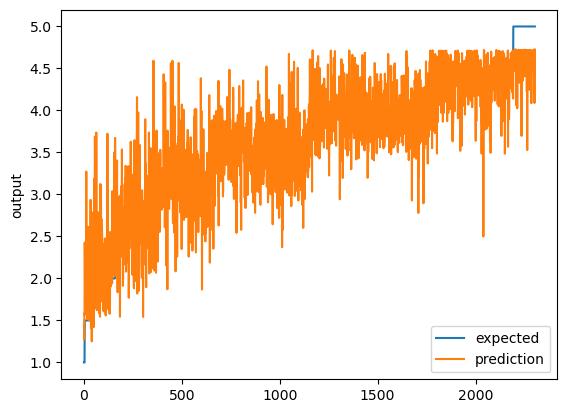

1. Business name: Target, Expected Rating: 4.5, Predicted Rating: [2.823116]
2. Business name: St Honore Pastries, Expected Rating: 4.0, Predicted Rating: [3.1588938]
3. Business name: Denny's, Expected Rating: 4.5, Predicted Rating: [3.9523337]
4. Business name: Zio's Italian Market, Expected Rating: 4.5, Predicted Rating: [3.164139]
5. Business name: Tuna Bar, Expected Rating: 4.0, Predicted Rating: [3.6149197]


In [50]:
# Get best model results
rmse = model_results['rmse'][21]
pred = model_results['pred'][21]

# Prints RMSE and lift chart for the best model
print("Score (RMSE): {}".format(rmse))
chart_regression(pred.flatten(),y_test)

# Compar
for i in range(5):
    print("{}. Business name: {}, Expected Rating: {}, Predicted Rating: {}".format(i+1,business.iloc[i]['name'],y[i],pred[i]))

## Restaurant Specific Model Testing

In [51]:
# Convert Data from JSON to Pandas
reviews = pd.read_json('yelp_academic_dataset_review.json', lines=True, nrows=1000000)

business = pd.read_json('yelp_academic_dataset_business.json', lines=True, nrows=1000000)

# Rename to distinguish star ratings after join
reviews = reviews.rename(columns={'stars': 'review_rating'})
business = business.rename(columns={'stars': 'business_rating'})

In [52]:
business['categories'].head()

0    Doctors, Traditional Chinese Medicine, Naturop...
1    Shipping Centers, Local Services, Notaries, Ma...
2    Department Stores, Shopping, Fashion, Home & G...
3    Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4                            Brewpubs, Breweries, Food
Name: categories, dtype: object

In [55]:
# Add Location Column
business['location'] = business['city'] + ", " + business['state']

# Filter businesses out (review_count < 20 and null business_id & review_count)
business =  business[business.review_count > 20]

# print("Before : ", business.shape)

# Only business reviews that are restaurants
business['is_restaurant'] = business['categories'].str.contains('Restaurants', case=False, na=False)
business =  business[business['is_restaurant'] == True]

print("After : ", business.shape)


After :  (33217, 16)


In [56]:
# Merge the business and reviews together 
all_reviews = pd.merge(reviews,business, on='business_id') 

print(all_reviews.columns)
all_reviews.head()
# all_reviews.head()

Index(['review_id', 'user_id', 'business_id', 'review_rating', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_rating',
       'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'location', 'is_restaurant'],
      dtype='object')


,review_id,user_id,business_id,review_rating,useful,funny,cool,text,date,name,...,latitude,longitude,business_rating,review_count,is_open,attributes,categories,hours,location,is_restaurant
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...","North Wales, PA",True
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,...,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None,"Tucson, AZ",True
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...","Philadelphia, PA",True
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,...,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","New Orleans, LA",True
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,Dmitri's,...,39.938013,-75.148131,4.0,273,0,"{'BusinessParking': '{'garage': False, 'street...","Mediterranean, Restaurants, Seafood, Greek","{'Wednesday': '17:30-21:0', 'Thursday': '17:30...","Philadelphia, PA",True


In [57]:
# Combine all the business's reviews into one text
business_reviews = all_reviews.groupby('business_id')['text'].sum()

# # Create a dataframe with the business and its all its cooresponding reviews
df_business_reviews = pd.DataFrame({
  'business_id' : business_reviews.index, 
  'all_reviews' : business_reviews.values,
})

df_business_reviews = pd.merge(df_business_reviews, business[['business_id', 'location', 'review_count', 'business_rating']], on='business_id')

In [58]:
# One hot encoding for location
df_encoded = pd.get_dummies(df_business_reviews['location'])
df_business_reviews = pd.concat([df_encoded, df_business_reviews], axis=1)

# Drop location column now that one)
df_business_reviews.drop(['location'], axis=1, inplace=True)


# Replace nulls with mean and normalize review count for the business
missing_median(df_business_reviews, 'review_count')
encode_numeric_zscore(df_business_reviews, 'review_count')

df_business_reviews.head()

,"Abington Township, PA","Abington, PA","Affton, MO","Aldan, PA","Alton, IL","Ambler, PA","Antioch, TN","Apollo Beach, FL","Arabi, LA","Ardmore, PA",...,"Wynnewood, PA","Yardley, PA","Yeadon, PA","Zephyrhills, FL","Zionsville, IN","wilmington, DE",business_id,all_reviews,review_count,business_rating
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,-0.490067,4.5
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-0TffRSXXIlBYVbb5AwfTg,We went for my husbands birthday in a fairly l...,4.569832,4.5
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-0jzoPt3UeXn6FUXVQvyPg,Went to the movies downtown and decided to gra...,0.089564,4.5
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-1MhPXk1FglglUAmuPLIGg,Great food and drink. The staff are always fri...,-0.133736,4.0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-2Axhv9AZ_n7qjQefECpVw,"The service was excellent, extremely friendly....",-0.542329,3.5


In [59]:
text = df_business_reviews['all_reviews']
text.head()

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,min_df=1)
# Fit and transform the aggregated reviews into a TF-IDF matrix
tfidf_wm = vectorizer.fit_transform(text)

# Retrieve the feature names (i.e., the vocabulary)
tfidf_tokens = vectorizer.get_feature_names_out()

# Create a DataFrame from the TF-IDF matrix for easier viewing
df_tfidfvect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

In [60]:
# Combine x and y into a single DataFrame
df_combined = pd.concat([df_tfidfvect, df_business_reviews['business_rating']], axis=1)

# Use the to_xy function to convert the DataFrame to x and y arrays
x, y = to_xy(df_combined, 'business_rating')

# Now split the transformed data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Check the shape of the resulting arrays
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5123, 1000) (5123,) (1281, 1000) (1281,)


In [61]:
model_results = []

# This time train all the models on RESTAURANT reviews
for model in model_types:
    hidden_layer = model['hidden_layers']
    activation_function = model['activation_function']
    optimizer = model['optimizer']
    dropout_rate = model['dropout_rate']
    learning_rate = model['learning_rate']
    batch_size = model['batch_size']
    
    results = model_tester(
        hidden_layers=hidden_layer, 
        learning_rate=learning_rate, 
        optimizer=optimizer,
        activation_function=activation_function, 
        dropout_rate=dropout_rate, 
        batch_size=batch_size
    )

    model_results.append(results)

Epoch 1/100
161/161 - 4s - loss: 0.4063 - val_loss: 0.2550 - 4s/epoch - 24ms/step
Epoch 2/100
161/161 - 1s - loss: 0.1312 - val_loss: 0.1637 - 863ms/epoch - 5ms/step
Epoch 3/100
161/161 - 1s - loss: 0.1248 - val_loss: 0.1602 - 835ms/epoch - 5ms/step
Epoch 4/100
161/161 - 1s - loss: 0.0910 - val_loss: 0.1306 - 832ms/epoch - 5ms/step
Epoch 5/100
161/161 - 1s - loss: 0.0826 - val_loss: 0.1273 - 830ms/epoch - 5ms/step
Epoch 6/100
161/161 - 1s - loss: 0.0737 - val_loss: 0.1462 - 777ms/epoch - 5ms/step
Epoch 7/100
161/161 - 1s - loss: 0.0672 - val_loss: 0.1557 - 778ms/epoch - 5ms/step
Epoch 7: early stopping
41/41 [==============================] - 0s 2ms/step
Epoch 1/100
161/161 - 2s - loss: 0.7582 - val_loss: 0.5402 - 2s/epoch - 16ms/step
Epoch 2/100
161/161 - 1s - loss: 0.5517 - val_loss: 0.5371 - 871ms/epoch - 5ms/step
Epoch 3/100
161/161 - 1s - loss: 0.5488 - val_loss: 0.5397 - 864ms/epoch - 5ms/step
Epoch 4/100
161/161 - 1s - loss: 0.5451 - val_loss: 0.5420 - 852ms/epoch - 5ms/step
Epo

In [62]:
# Combine model types with model_results
for i, result in enumerate(model_results):
    model_types[i]['rmse'] = result[0]
    model_types[i]['pred'] = result[1]  


# Create a DataFrame
model_results = pd.DataFrame(model_types)

model_results

,hidden_layers,activation_function,optimizer,dropout_rate,pred,rmse,learning_rate,batch_size
0,"[256, 128, 64]",relu,adam,0.2,"[[2.9192328], [4.285638], [3.8782258], [3.5654...",0.356806,0.010,32
1,"[256, 128, 64]",sigmoid,adam,0.2,"[[3.5475597], [3.5475655], [3.5475447], [3.547...",0.732850,0.010,32
2,"[256, 128, 64]",tanh,adam,0.2,"[[3.0422873], [4.30152], [3.6967545], [3.91610...",0.345565,0.010,32
3,"[256, 128, 64]",relu,sgd,0.2,"[[2.9048324], [4.501037], [3.8296876], [3.9478...",0.335181,0.010,32
4,"[256, 128, 64]",sigmoid,sgd,0.2,"[[3.5827038], [3.5851471], [3.5836062], [3.582...",0.730339,0.010,32
5,"[256, 128, 64]",tanh,sgd,0.2,"[[3.121858], [4.628701], [3.921926], [3.996370...",0.365277,0.010,32
6,"[512, 256, 128, 64]",relu,adam,0.2,"[[2.9659743], [4.454187], [3.9854443], [4.2603...",0.351781,0.001,32
7,"[512, 256, 128, 64]",sigmoid,adam,0.2,"[[2.8315387], [4.40432], [3.7849524], [3.97826...",0.329665,0.001,32
8,"[512, 256, 128, 64]",tanh,adam,0.2,"[[2.9539814], [4.3454013], [3.7917597], [4.146...",0.335666,0.001,32
9,"[512, 256, 128, 64]",relu,sgd,0.2,"[[2.8483715], [4.6102724], [3.7439427], [3.936...",0.336701,0.001,32


Score (RMSE): 0.3278100788593292


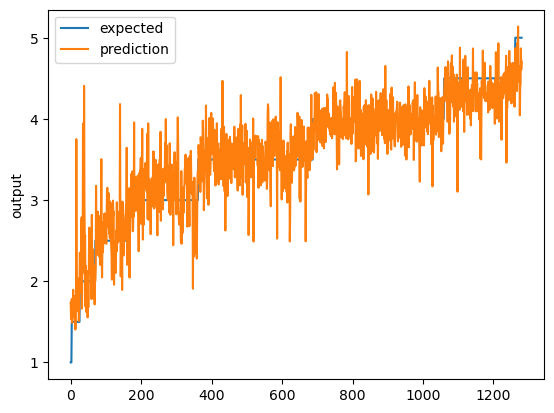

1. Business name: St Honore Pastries, Expected Rating: 4.5, Predicted Rating: [2.7327242]
2. Business name: Denny's, Expected Rating: 4.5, Predicted Rating: [4.362261]
3. Business name: Zio's Italian Market, Expected Rating: 4.5, Predicted Rating: [3.8233552]
4. Business name: Tuna Bar, Expected Rating: 4.0, Predicted Rating: [4.149211]
5. Business name: BAP, Expected Rating: 3.5, Predicted Rating: [2.9671788]


In [63]:
# Get best model results
rmse = model_results['rmse'][12]
pred = model_results['pred'][12]

# Prints RMSE and lift chart for the best model
print("Score (RMSE): {}".format(rmse))
chart_regression(pred.flatten(),y_test)

# Compar
for i in range(5):
    print("{}. Business name: {}, Expected Rating: {}, Predicted Rating: {}".format(i+1,business.iloc[i]['name'],y[i],pred[i]))